In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import numpy as np
import matplotlib.pyplot as plt

from ase.io import read
from abtem.plot import show_atoms
from abtem.waves import Probe
from abtem.potentials import Potential
from abtem.scan import GridScan
from tqdm.auto import tqdm

atoms = read('graphene.cif') * (5, 3, 1)
atoms.center(vacuum=3,axis=2)

probe = Probe(energy=80e3, semiangle_cutoff=.03, focal_spread=40, defocus=-30)
potential = Potential(atoms, sampling=.05, slice_thickness=1).calculate().as_transmission_functions(probe.energy)
gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=.1)

(<matplotlib.axes._subplots.AxesSubplot at 0x1d163a00608>,
 <matplotlib.image.AxesImage at 0x1d163a07f08>)

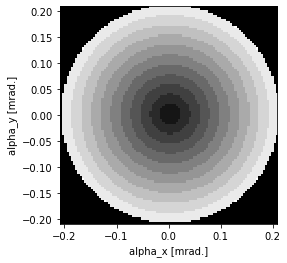

In [40]:
from abtem.detect import _PolarDetector

probe = Probe(energy=80e3, semiangle_cutoff=.03, focal_spread=40, defocus=-30, extent=10, sampling=.05)

d = _PolarDetector(inner=.0,radial_steps=.02)

w = probe.build()

d.show(probe.grid, probe.wavelength)


#for i in tqdm(range(10000)):
#d.detect(w)

## Segmented detector

The `SegmentedDetector` is partitioned into several integration regions divided at radials and angles. This can be used for simulating for simulating differential phase contrast (DPC) imaging. 

In [5]:
from abtem.detect import AdjustableAnnularDetector
dpc_detector = SegmentedDetector(inner = .09, outer=.2, nbins_radial=2, nbins_angular=4)

dpc_detector.show(potential.grid, probe.wavelength, cmap='jet', colorbar=True);

TypeError: Can't instantiate abstract class SegmentedDetector with abstract methods allocate_measurement

In [6]:
annular_detector = AdjustableAnnularDetector(.01)
annular_detector.show(potential.grid, probe.wavelength, cmap='jet', colorbar=True);

AttributeError: 'Grid' object has no attribute 'antialiased_grid'

In [5]:
measurements = probe.scan(gridscan, [dpc_detector, annular_detector], potential, max_batch=200, show_progress=True)

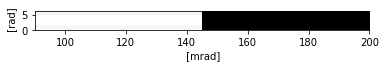

In [8]:
measurements[dpc_detector][0, 1].show()

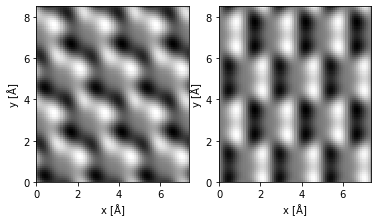

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
measurements[dpc_detector].difference(0, 2).tile((3,2)).show(ax = ax1)
measurements[dpc_detector].difference([0,1], [2,3]).tile((3,2)).show(ax = ax2)

An interesting usage case of t use of this detector is as a flexible `AnnularDetector`, by choosing a single angular bin and dense sampling of radial bins.

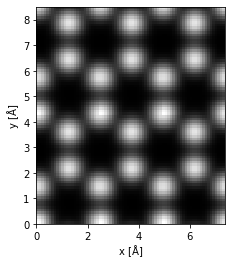

In [10]:
measurements[annular_detector].sum(range(10, 19)).tile((3,2)).show()

## Pixelated detector

The default use for `PixelatedDetector` object is to save the intensity of the fourier transformed exit wave function, i.e. a complete convergent beam electron diffraction pattern. Hence a 2D scan with this detector results in a large four-dimensional dataset (a 2D diffraction pattern recorded at every 2D probe position). The 4D datasets generated can reconstruct the results of any of the other detector geometries, hence the only downside of using this is the high memory or disk space requirement of storing the data. Optionally this can be mitigated by choosing a downscaling factor or a maximum recorded spatial frequency.

In [11]:
from abtem.detect import PixelatedDetector

pixelated_detector = PixelatedDetector()

In [12]:
measurements = probe.scan(gridscan, [pixelated_detector], potential, max_batch=200)

(<matplotlib.axes._subplots.AxesSubplot at 0x1cd7842b888>,
 <matplotlib.image.AxesImage at 0x1cd0053cec8>)

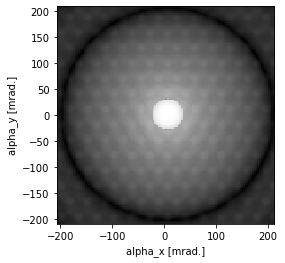

In [13]:
measurements[pixelated_detector][0,0].show(display_func=np.log)

(<matplotlib.axes._subplots.AxesSubplot at 0x1cd005f8b48>,
 <matplotlib.image.AxesImage at 0x1cd005bc5c8>)

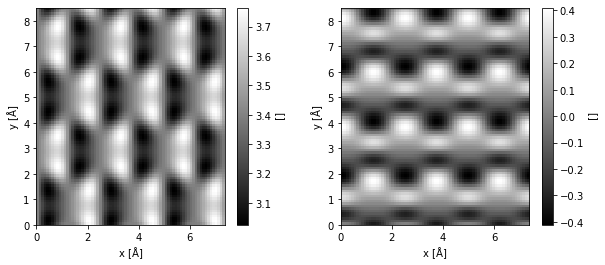

In [14]:
com_x, com_y = measurements[pixelated_detector].center_of_mass()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
com_x.tile((3,2)).show(colorbar=True, ax=ax1)
com_y.tile((3,2)).show(colorbar=True, ax=ax2)